# Interstate 94 - Hourly traffic volume prediction (multivariate time series)

In this tutorial, we demonstrate a time series application of getML. We predict the hourly traffic volume on I-94 westbound from Minneapolis-St Paul.
We benchmark our results against [Facebook's Prophet](https://facebook.github.io/prophet/). getML's relational learning algorithms outperform Prophet's classical time series approach by ~15%.

Summary:

- Prediction type: __Regression model__
- Domain: __Transportation__
- Prediction target: __Hourly traffic volume__
- Source data: __Multivariate time series, 5 components__
- Population size: __24096__

## Background

The dataset features some particularly interesting characteristics common for time series, which classical models may struggle to deal with appropriately. Such characteristics are:

- High frequency (hourly)
- Dependence on irregular events (holidays)
- Strong and overlapping cycles (daily, weekly)
- Anomalies
- Multiple seasonalities


The analysis is built on top of a dataset provided by the [MN Department of Transportation](https://www.dot.state.mn.us), with some data preparation done by [John Hogue](https://github.com/dreyco676/Anomaly_Detection_A_to_Z/).

## Analysis

Let's get started with the analysis and set-up your session:

In [5]:
%pip install -q "getml==1.5.0" "matplotlib==3.9.2" "scipy==1.14.1" "cmdstanpy==1.2.4" "Prophet==1.1.5" "plotly==5.24.0" "ipywidgets==8.1.5"

In [ ]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import getml

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

print(f"getML API version: {getml.__version__}\n")

getML API version: 1.5.0



In [ ]:
getml.engine.launch(allow_remote_ips=True, token="token")
getml.engine.set_project("interstate94")

Launching ./getML --allow-push-notifications=true --allow-remote-ips=true --home-directory=/home/user --in-memory=true --install=false --launch-browser=true --log=false --token=token in /home/user/.getML/getml-1.5.0-x64-linux...
Launched the getML Engine. The log output will be stored in /home/user/.getML/logs/20240912144337.log.
  Loading pipelines... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


Connected to project 'interstate94'.

### 1. Loading data

#### 1.1 Download from source

Downloading the raw data and convert it into a prediction ready format takes time. To get to the getML model building as fast as possible, we prepared the data for you and excluded the code from this notebook. It is made available in the example notebook featuring the full analysis. We only include data after 2016 and introduced a fixed train/test split at 80% of the available data.

In [8]:
traffic = getml.datasets.load_interstate94()

In [9]:
traffic

name,ds,traffic_volume,holiday,day,month,weekday,hour,year
role,time_stamp,target,categorical,categorical,categorical,categorical,categorical,categorical
unit,"time stamp, comparison only",,,day,month,weekday,hour,year
0,2016-01-01,1513,New Years Day,1,1,4,0,2016
1,2016-01-01 01:00:00,1550,New Years Day,1,1,4,1,2016
2,2016-01-01 02:00:00,993,New Years Day,1,1,4,2,2016
3,2016-01-01 03:00:00,719,New Years Day,1,1,4,3,2016
4,2016-01-01 04:00:00,533,New Years Day,1,1,4,4,2016
,...,...,...,...,...,...,...,...
24091,2018-09-30 19:00:00,3543,No holiday,30,9,6,19,2018
24092,2018-09-30 20:00:00,2781,No holiday,30,9,6,20,2018


#### 1.2 Prepare data for getML

The `getml.datasets.load_interstate94` method took care of the entire data preparation:
* Downloads csv's from our servers into python
* Converts csv's to getML [DataFrames](https://getml.com/latest/reference/data/data_frame#dataframe)
* Sets [roles](https://getml.com/latest/user_guide/concepts/annotating_data#roles) & [units](https://getml.com/latest/user_guide/concepts/annotating_data#annotating-units) to columns inside getML DataFrames

__Data visualization__

The first week of the original traffic time series is plotted below.

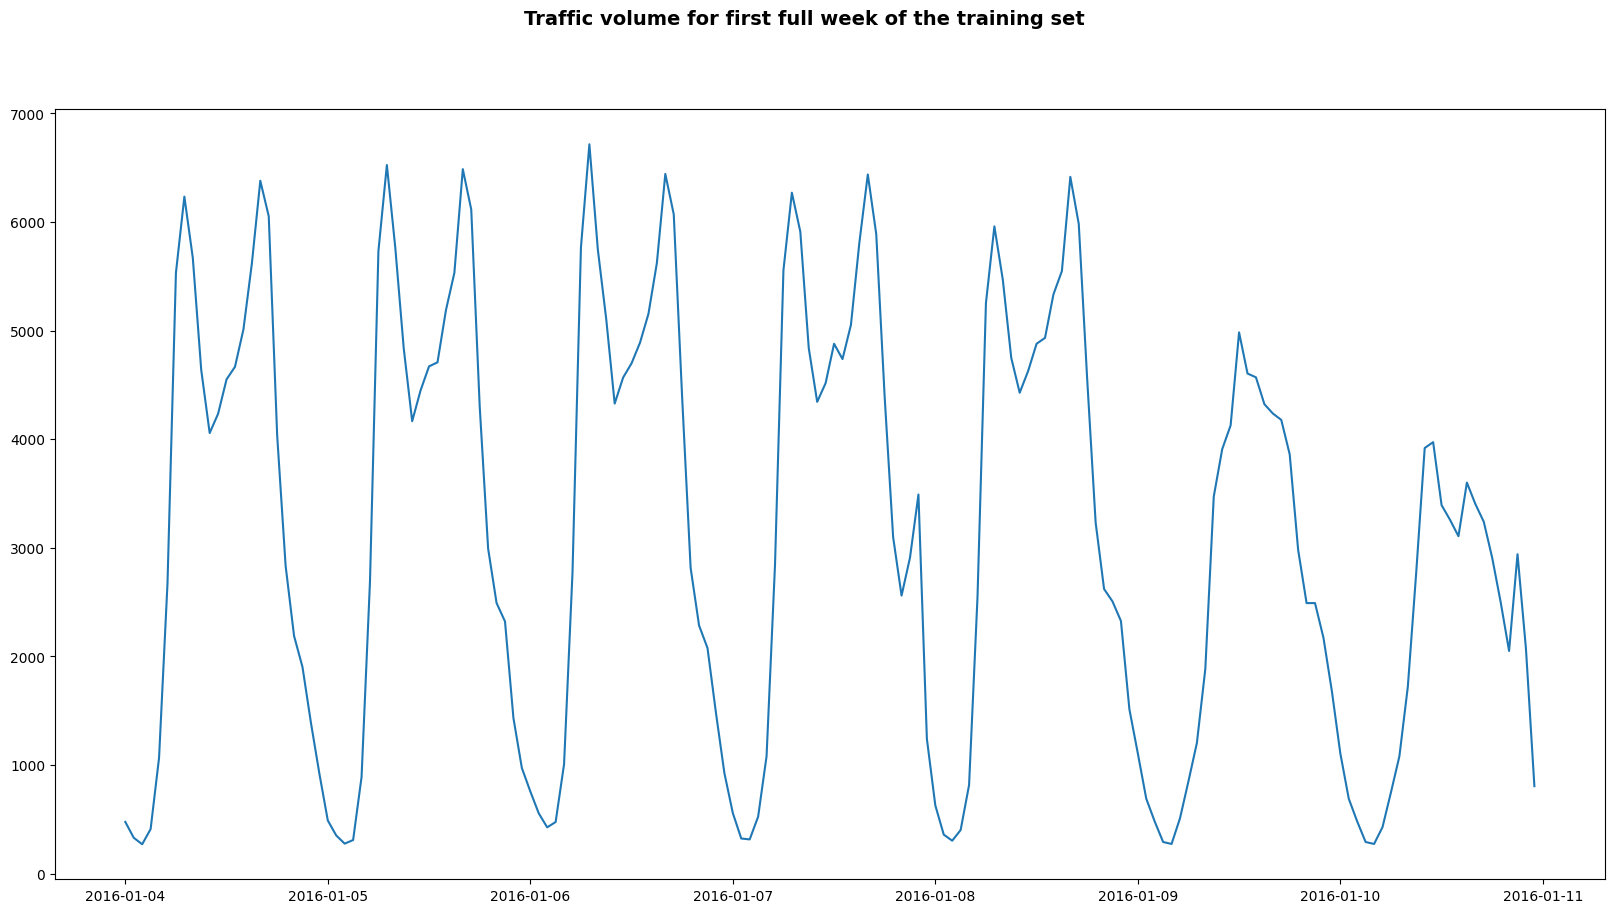

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

# 2016/01/01 was a friday, we'd like to start the visualizations on a monday
start = getml.data.time.datetime(2016, 1, 4)
end = getml.data.time.datetime(2016, 1, 11)

fig.suptitle(
    "Traffic volume for first full week of the training set",
    fontsize=14,
    fontweight="bold",
)
traffic_first_week = traffic[(traffic.ds >= start) & (traffic.ds < end)]
ax.plot(
    traffic_first_week["ds"].to_numpy(),
    traffic_first_week["traffic_volume"].to_numpy(),
)

__Traffic__: population table

To allow the algorithm to capture seasonal information, we include time components (such as the day of the week) as categorical variables. Note that we could have also used getML's Seasonal preprocessor (`getml.prepreprocessors.Seasonal()`), but in this case the information was already included in the dataset.

__Train/test split__

We use [getML's split functionality](https://getml.com/latest/reference/data/split) to retrieve a lazily evaluated split column, that we can supply to the time series api below.

In [11]:
split_date = pd.Timestamp(year=2018, month=3, day=15)
split = getml.data.split.time(traffic, "ds", test=split_date.timestamp())

Split columns are columns of mere strings that can be used to subset the data by forming bolean conditions over them:

In [12]:
traffic[split == "test"]

name,ds,traffic_volume,holiday,day,month,weekday,hour,year
role,time_stamp,target,categorical,categorical,categorical,categorical,categorical,categorical
unit,"time stamp, comparison only",,,day,month,weekday,hour,year
0,2018-03-15,577,No holiday,15,3,3,0,2018
1,2018-03-15 01:00:00,354,No holiday,15,3,3,1,2018
2,2018-03-15 02:00:00,259,No holiday,15,3,3,2,2018
3,2018-03-15 03:00:00,360,No holiday,15,3,3,3,2018
4,2018-03-15 04:00:00,910,No holiday,15,3,3,4,2018
...,...,...,...,...,...,...,...,...


#### 1.3 Define relational model

To start with relational learning, we need to specify the data model. We manually replicate the appropriate time series structure by setting time series related join conditions (`horizon`, `memory` and `allow_lagged_targets`). We use the [high-level time series api](https://getml.com/latest/reference/data/time_series) for this.

Under the hood, the time series api abstracts away a self cross join of the population table (`traffic`) that allows getML's feature learning algorithms to learn patterns from past observations.

In [13]:
time_series = getml.data.TimeSeries(
    population=traffic,
    split=split,
    time_stamps="ds",
    horizon=getml.data.time.hours(1),
    memory=getml.data.time.days(7),
    lagged_targets=True,
)

time_series

data model

  population:
    columns:
    - holiday: categorical
    - day: categorical
    - month: categorical
    - weekday: categorical
    - hour: categorical
    - ...

    joins:
    - right: 'traffic'
      time_stamps: (population.ds, traffic.ds)
      relationship: 'many-to-many'
      memory: 604800.0
      horizon: 3600.0
      lagged_targets: True

  traffic:
    columns:
    - holiday: categorical
    - day: categorical
    - month: categorical
    - weekday: categorical
    - hour: categorical
    - ...


container

  population
      subset   name       rows   type
  0   test     traffic    4800   View
  1   train    traffic   19296   View

  peripheral
      name       rows   type     
  0   traffic   24096   DataFrame

### 2.Predictive modeling

We loaded the data, defined the roles, units and the abstract data model. Next, we create a getML pipeline for relational learning.

#### 2.1 getML Pipeline

<!-- #### 2.1.1  -->
__Set-up of feature learners, selectors & predictor__

In [14]:
relmt = getml.feature_learning.RelMT(
    num_features=20,
    loss_function=getml.feature_learning.loss_functions.SquareLoss,
    seed=4367,
    num_threads=1,
)

predictor = getml.predictors.XGBoostRegressor()

__Build the pipeline__

In [15]:
pipe = getml.pipeline.Pipeline(
    tags=["memory: 7d", "horizon: 1h", "relmt"],
    data_model=time_series.data_model,
    feature_learners=[relmt],
    predictors=[predictor],
)

#### 2.2 Model training

In [16]:
pipe.fit(time_series.train)

Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00


OK.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  RelMT: Training features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 02:16
  RelMT: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:33
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:01


Trained pipeline.

Time taken: 0:02:52.016844.



Pipeline(data_model='population',
         feature_learners=['RelMT'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='SquareLoss',
         peripheral=['traffic'],
         predictors=['XGBoostRegressor'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['memory: 7d', 'horizon: 1h', 'relmt', 'container-qXknDH'])

#### 2.3 Model evaluation

In [17]:
getml_score = pipe.score(time_series.test)
getml_score

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  RelMT: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:07


,date time,set used,target,mae,rmse,rsquared
0,2024-09-12 12:55:01,train,traffic_volume,203.9053,299.4105,0.9768
1,2024-09-12 12:55:09,test,traffic_volume,184.7593,273.3406,0.9811


#### 2.4 Studying features

__Feature correlations__

Correlations of the calculated features with the target

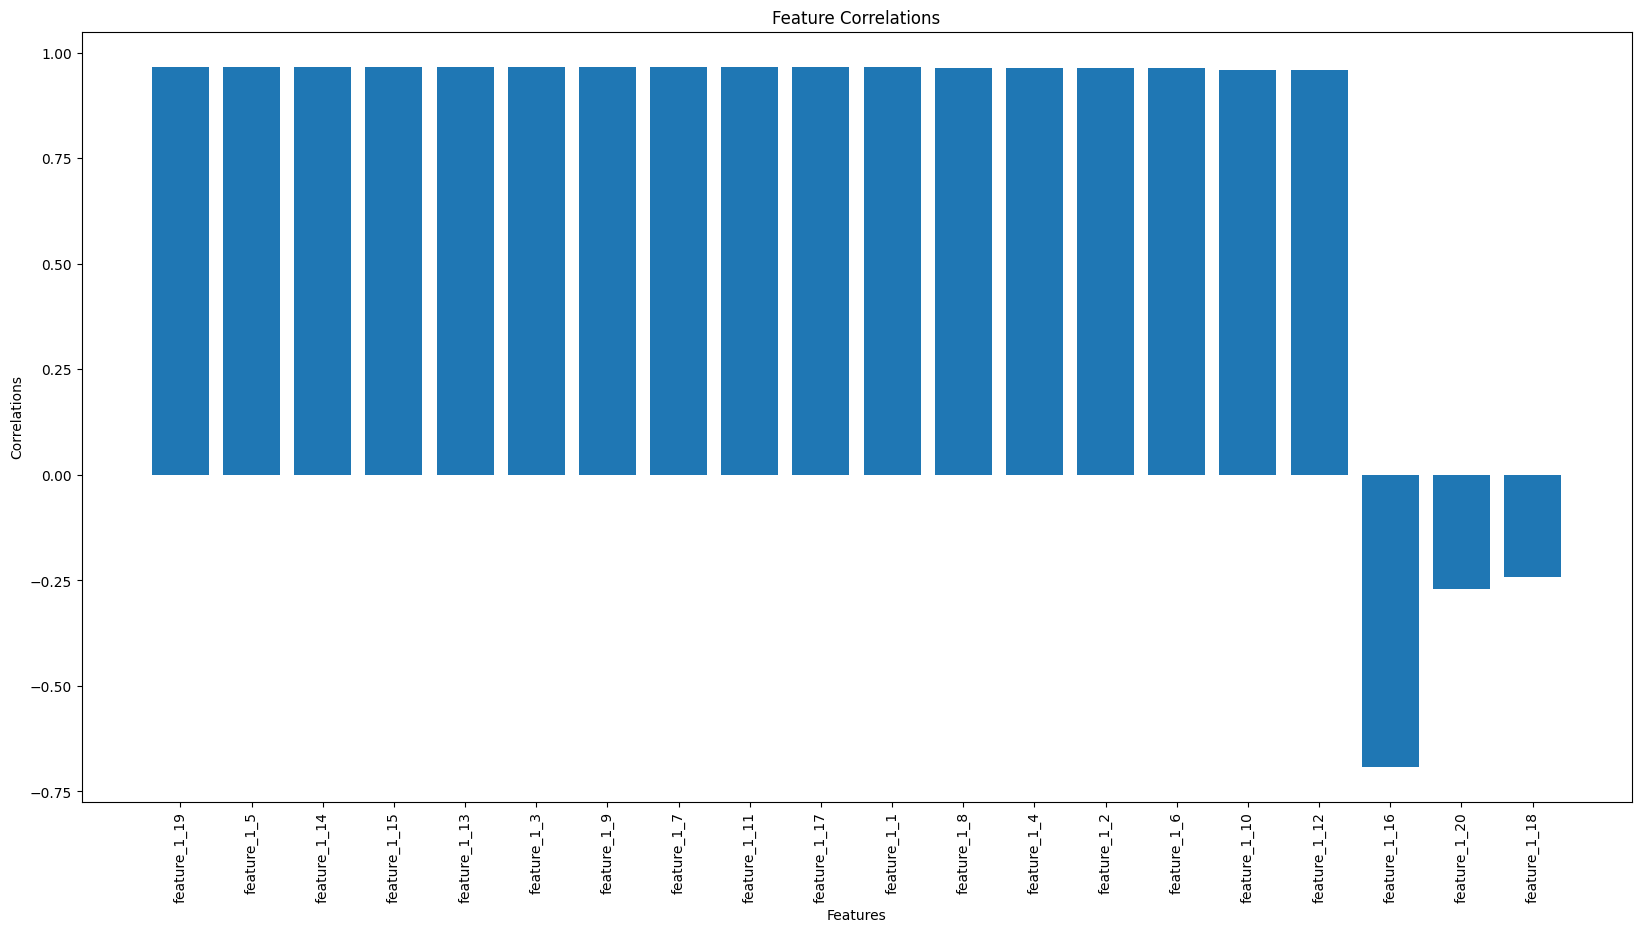

In [18]:
names, correlations = pipe.features.correlations()

plt.subplots(figsize=(20, 10))

plt.bar(names, correlations)
plt.title("Feature Correlations")
plt.xlabel("Features")
plt.ylabel("Correlations")
plt.xticks(rotation="vertical")
plt.show()

__Feature importances__

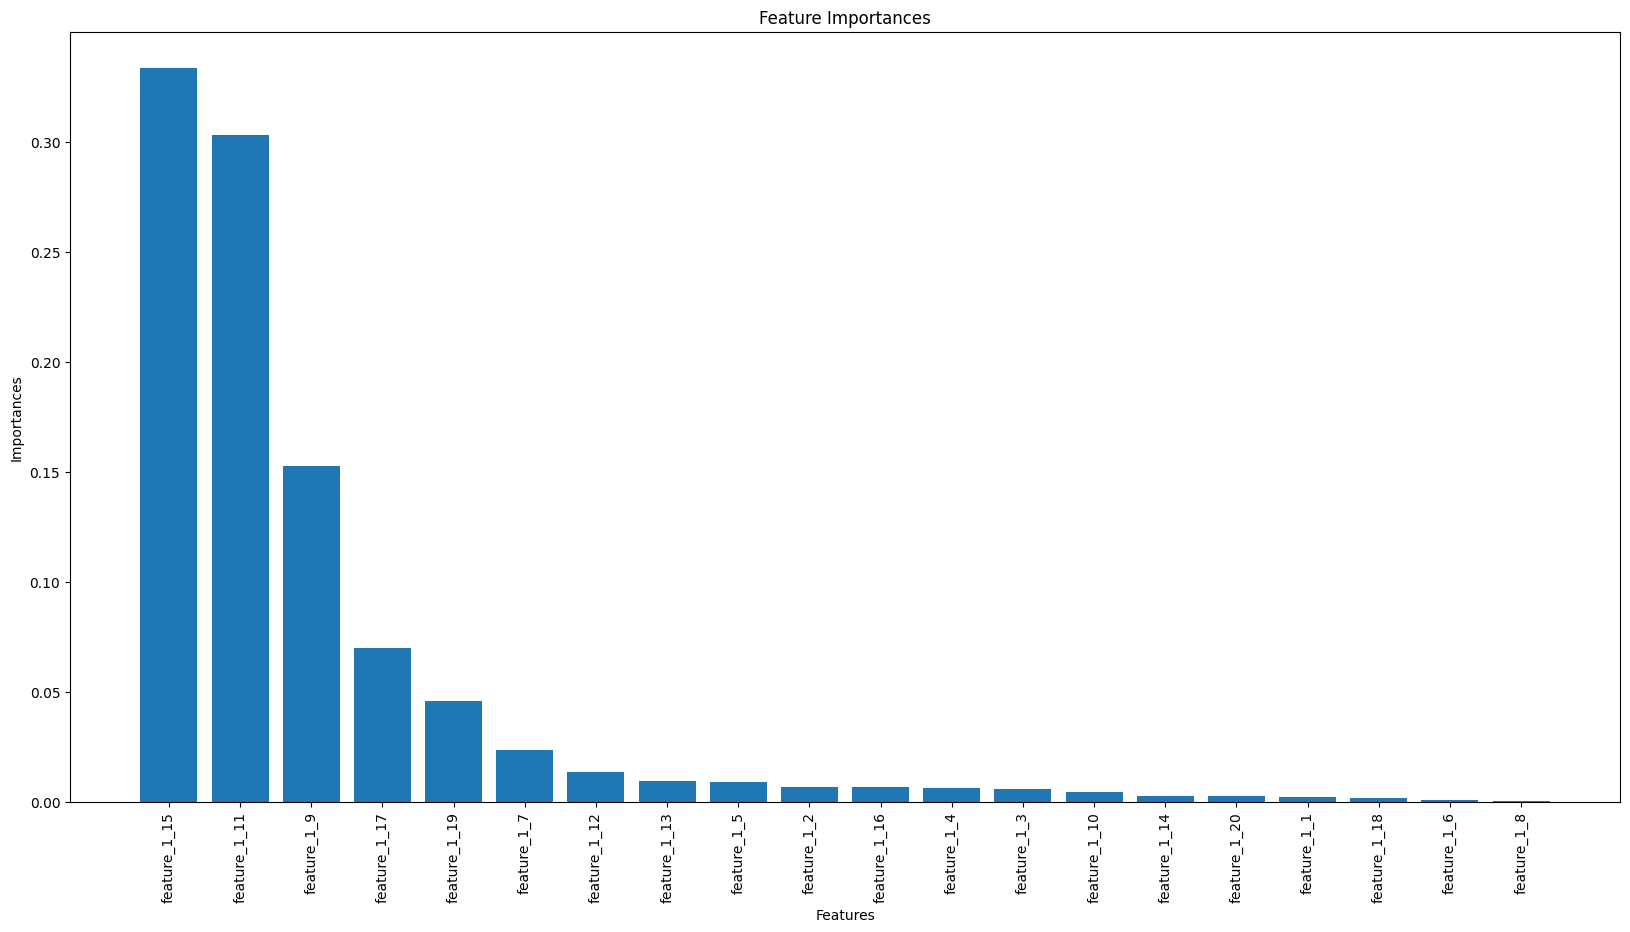

In [19]:
names, importances = pipe.features.importances()

plt.subplots(figsize=(20, 10))

plt.bar(names, importances)
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importances")
plt.xticks(rotation="vertical")
plt.show()

__Visualizing the learned features__

We can also transpile the features as SQL code. Here, we show the most important feature.

In [20]:
by_importance = pipe.features.sort(by="importance")
by_importance[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_15";

CREATE TABLE "FEATURE_1_15" AS
SELECT SUM( 
    CASE
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * 1.705917878584984e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.0001936231536392765 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -8.056960230057425e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -8.056957944693151e-06 + 4.5250889726136045e+01
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * -0.0002163034976421974 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * -0.006418032044048922 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 0.0001065314179104133 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * 0.0001065314179104392 + -8.9213352885842269e+01
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * -3.82475680050204e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.3034691874247781 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -3.831784833579947e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -3.831784833797431e-06 + -4.2976609616817029e+01
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * -5.04897333464575e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.6151515390903501 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -5.372500965248551e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -5.372500965185837e-06 + 7.1864825789196652e+02
        ELSE NULL
    END
) AS "feature_1_15",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds__1_000000_hours" <= t1."ds"
AND ( t2."ds__7_041667_days" > t1."ds" OR t2."ds__7_041667_days" IS NULL )
GROUP BY t1.rowid;
```

To showcase getML's ability to handle categorical data, we now look for features that contain information from the holiday column:

In [21]:
w_holiday = by_importance.filter(lambda feature: "holiday" in feature.sql)
w_holiday

,target,name,correlation,importance
0,traffic_volume,feature_1_12,0.9598,0.0135823
1,traffic_volume,feature_1_5,0.9669,0.0089131
2,traffic_volume,feature_1_2,0.9633,0.006621
3,traffic_volume,feature_1_4,0.9633,0.0062863
4,traffic_volume,feature_1_3,0.9661,0.0056305
5,traffic_volume,feature_1_10,0.9601,0.0045644
6,traffic_volume,feature_1_14,0.9665,0.0028168
7,traffic_volume,feature_1_1,0.9653,0.002152
8,traffic_volume,feature_1_6,0.963,0.000826
9,traffic_volume,feature_1_8,0.9648,0.0004109


As you can see, getML features which incorporate information about holidays have a rather low importance. This is not that surprising given the fact that most information about holidays is fully reproducible from the extracted calendarial information that is already present. In other words: for the algorithm, it doesn't matter if the traffic is lower on every 4th of July of a given year or if there is a corresponding holiday named 'Independence Day'. Here is the SQL transpilation of the most important feature relying on information about holdidays anyway:

In [22]:
w_holiday[0].sql

```sql
DROP TABLE IF EXISTS "FEATURE_1_12";

CREATE TABLE "FEATURE_1_12" AS
SELECT AVG( 
    CASE
        WHEN ( t1."ds" - t2."ds" > 604379.580420 ) AND ( t2."holiday" IN ( 'No holiday' ) ) THEN COALESCE( t1."ds" - 1486345037.599149, 0.0 ) * 0.0003361531497934741 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 70.70602450793902 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 0.0003365257612470715 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * 0.0003365257612470736 + -1.4232019457357859e+02
        WHEN ( t1."ds" - t2."ds" > 604379.580420 ) AND ( t2."holiday" NOT IN ( 'No holiday' ) OR t2."holiday" IS NULL ) THEN COALESCE( t1."ds" - 1486345037.599149, 0.0 ) * 5.082103619613134e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 68.37913063532808 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 5.087270877254782e-05 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * 5.087270877254777e-05 + 5.0724804065820763e+02
        WHEN ( t1."ds" - t2."ds" <= 604379.580420 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t1."ds" - t2."ds" > 6952.594670 ) THEN COALESCE( t1."ds" - 1486345037.599149, 0.0 ) * -1.10962043270733e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.0474280195060898 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -1.145497543383722e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -1.145497543228575e-06 + 7.8261472233316871e+00
        WHEN ( t1."ds" - t2."ds" <= 604379.580420 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t1."ds" - t2."ds" <= 6952.594670 OR t1."ds" IS NULL OR t2."ds" IS NULL ) THEN COALESCE( t1."ds" - 1486345037.599149, 0.0 ) * -0.0001623349073019203 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 9.234221916172794 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -0.0001624870975043922 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -0.0001624870975043915 + -9.4781762415471817e+00
        ELSE NULL
    END
) AS "feature_1_12",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds__1_000000_hours" <= t1."ds"
AND ( t2."ds__7_041667_days" > t1."ds" OR t2."ds__7_041667_days" IS NULL )
GROUP BY t1.rowid;
```

__Plot predictions & traffic volume vs. time__

We now plot the predictions against the observed values of the target for the first 7 days of the testing set. You can see that the predictions closely follows the original series. RelMT was able to identify certain patterns in the series, including:
- Day and night separation
- The daily commuting peeks (on weekdays)
- The decline on weekends



In [23]:
predictions = pipe.predict(time_series.test)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:00
  RelMT: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:07


In [ ]:
# the test set starts at 2018/03/15 – a thursday; we introduce an offset to, once again, start on a monday
def limit_view(view):
    start_date = "2018-03-19"
    end_date = "2018-03-26"
    return view[(view.ds >= start_date) & (view.ds < end_date)]

In [ ]:
# Predict with getML
prediction_getml = pd.DataFrame(np.array(predictions), columns=["traffic_volume"])
prediction_getml["ds"] = time_series.test.population["ds"].to_numpy()
prediction_getml

,traffic_volume,ds
0,565.346191,2018-03-15 00:00:00
1,354.738586,2018-03-15 01:00:00
2,308.586731,2018-03-15 02:00:00
3,353.199097,2018-03-15 03:00:00
4,845.676880,2018-03-15 04:00:00
...,...,...
4795,3377.394043,2018-09-30 19:00:00
4796,3014.952393,2018-09-30 20:00:00
4797,2510.721191,2018-09-30 21:00:00
4798,1415.429199,2018-09-30 22:00:00


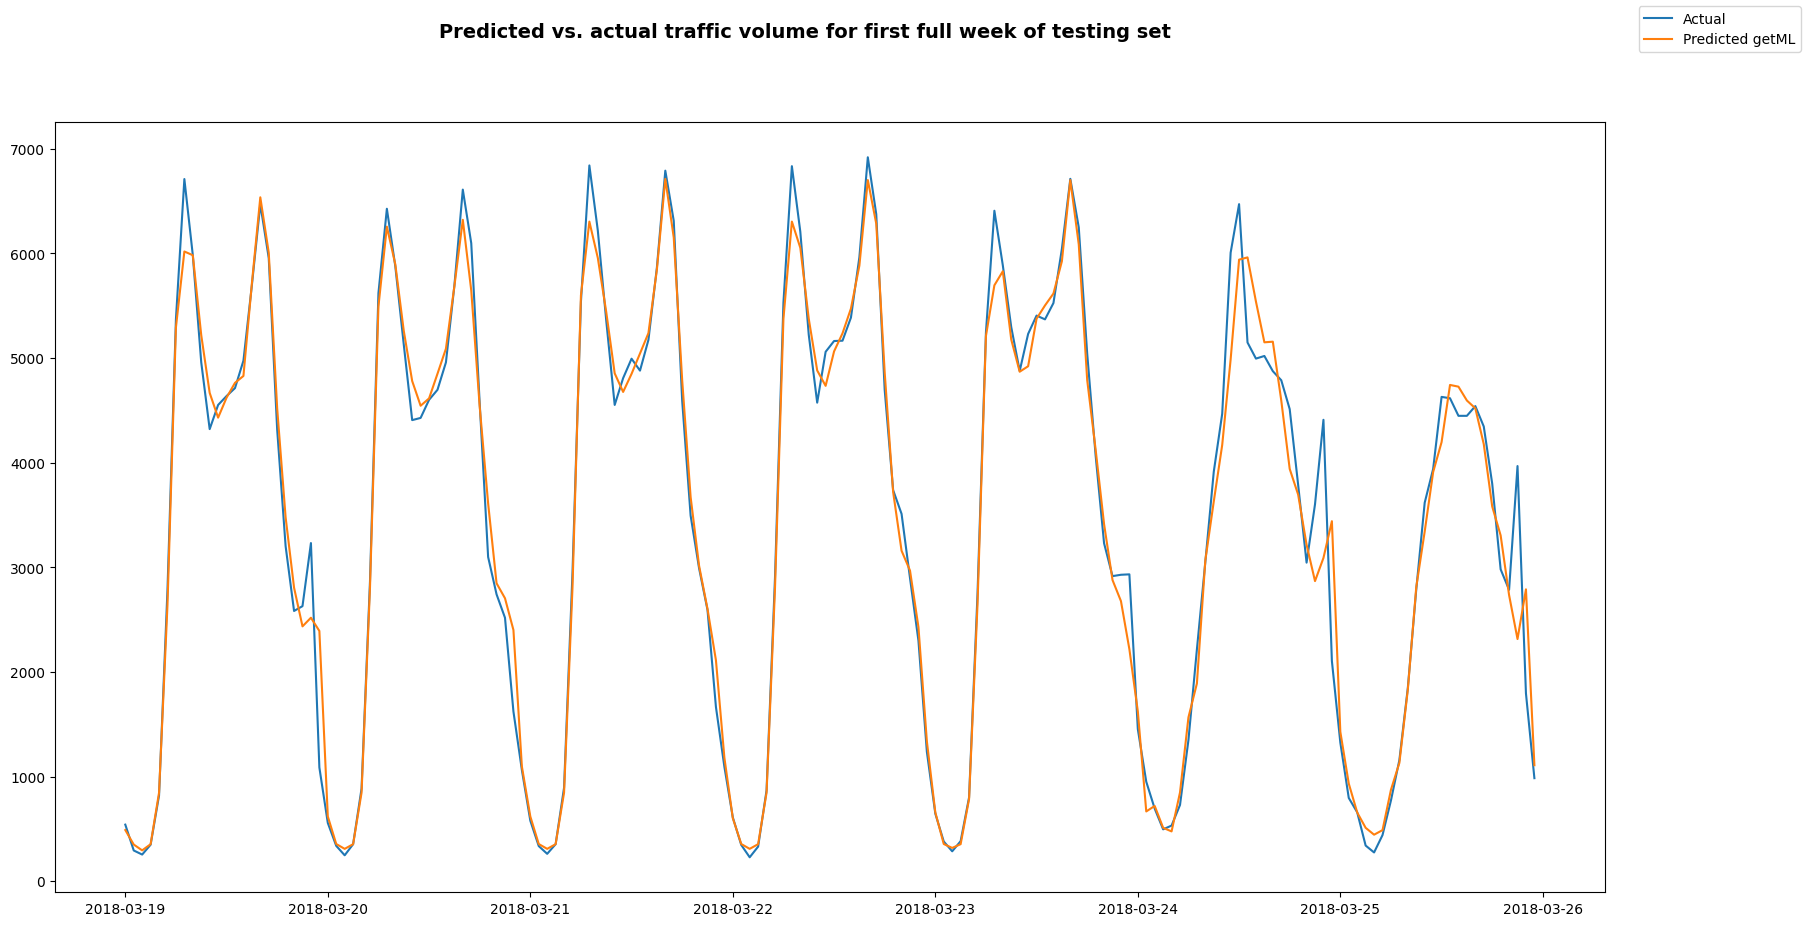

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

actual = limit_view(time_series.test.population.to_pandas())

ax.plot(actual["ds"], actual["traffic_volume"], label="Actual")
ax.plot(
    actual["ds"],
    limit_view(prediction_getml)["traffic_volume"],
    label="Predicted getML",
)
fig.suptitle(
    "Predicted vs. actual traffic volume for first full week of testing set",
    fontsize=14,
    fontweight="bold",
)
fig.legend()

#### 2.5 Features

The most important feature looks as follows:

In [27]:
pipe.features.to_sql()[pipe.features.sort(by="importances")[0].name]

```sql
DROP TABLE IF EXISTS "FEATURE_1_15";

CREATE TABLE "FEATURE_1_15" AS
SELECT SUM( 
    CASE
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * 1.705917878584984e-05 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.0001936231536392765 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -8.056960230057425e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -8.056957944693151e-06 + 4.5250889726136045e+01
        WHEN ( t1."ds" - t2."ds" > 6965.710287 ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * -0.0002163034976421974 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * -0.006418032044048922 + COALESCE( t2."ds" - 1486335600, 0.0 ) * 0.0001065314179104133 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * 0.0001065314179104392 + -8.9213352885842269e+01
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * -3.82475680050204e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.3034691874247781 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -3.831784833579947e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -3.831784833797431e-06 + -4.2976609616817029e+01
        WHEN ( t1."ds" - t2."ds" <= 6965.710287 OR t1."ds" IS NULL OR t2."ds" IS NULL ) AND ( t2."hour" NOT IN ( '0', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23' ) OR t2."hour" IS NULL ) THEN COALESCE( t1."ds" - 1486176242.728611, 0.0 ) * -5.04897333464575e-06 + COALESCE( t2."traffic_volume" - 3302.204612593936, 0.0 ) * 0.6151515390903501 + COALESCE( t2."ds" - 1486335600, 0.0 ) * -5.372500965248551e-06 + COALESCE( t2."ds__1_000000_hours" - 1486339200, 0.0 ) * -5.372500965185837e-06 + 7.1864825789196652e+02
        ELSE NULL
    END
) AS "feature_1_15",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "TRAFFIC__STAGING_TABLE_2" t2
ON 1 = 1
WHERE t2."ds__1_000000_hours" <= t1."ds"
AND ( t2."ds__7_041667_days" > t1."ds" OR t2."ds__7_041667_days" IS NULL )
GROUP BY t1.rowid;
```

#### 2.6 Productionization

It is possible to productionize the pipeline by transpiling the features into production-ready SQL code. Please also refer to getML's `sqlite3` module.

In [28]:
# Creates a folder named interstate94_pipeline containing
# the SQL code.
pipe.features.to_sql().save("interstate94_pipeline", remove=True)

While the feature is less smooth, it is really close to what we got in the 1-step case. This is another indication for the presence of strong time-related patterns in the data.

### 3. Benchmarks against Prophet

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. In order to retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross validating the model on a rolling origin. This clearly gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast. Prophet's performance thus has to be viewed as an upper bound. Further, as noted above, we thought it would be interesting to let Multirel and Relboost figure out time based patterns by itself if we provide only deterministic components. So, in a second step, we benchmark this case against Prophet. For both tools, we use very simple models with all hyperparameters set to their default values.

Here we fit the model. We fit a new Prophet model for every hour. This is a computationally expensive operation even for our test subsample of 30 days. For the 720 hours (= 720 models) it may take up to 6 hours. Therefore we read the predictions from disc. If you want to re-estimate the Prophet predictions, you can rename the csv files on disc.

In [ ]:
try:
    prediction_prophet = pd.read_csv("assets/pred_prophet_30d.csv")
    prediction_prophet["ds"] = pd.to_datetime(prediction_prophet["ds"])

except FileNotFoundError:
    import logging
    import cmdstanpy

    logger = logging.getLogger("cmdstanpy")
    logger.addHandler(logging.NullHandler())
    logger.propagate = False
    logger.setLevel(logging.CRITICAL)

    from prophet import Prophet
    from prophet.diagnostics import cross_validation

    # Rename columns to follow Prophet convention
    traffic_prophet = traffic.to_pandas()[["ds", "traffic_volume"]].rename(
        {"traffic_volume": "y"}, axis="columns"
    )

    # The actual prediction. One model for every 1h ahead prediction.
    fit_df = traffic_prophet[traffic_prophet.ds < split_date + pd.Timedelta("30d")]
    train_ds = traffic_prophet[traffic_prophet.ds < split_date]["ds"]
    train_window = train_ds.max() - train_ds.min()

    model_prophet = Prophet()
    model_prophet.fit(fit_df)

    # Cross validate
    prediction_prophet = cross_validation(
        model_prophet, horizon="1h", period="1h", initial=train_window
    )
    # Save predictions
    prediction_prophet.to_csv(
        "assets/pred_prophet_30d.csv", encoding="utf-8", index=False
    )

Score the model.

In [ ]:
# Calculate score
r2_prophet = (
    stats.pearsonr(prediction_prophet["yhat"].values, prediction_prophet["y"].values)[0]
    ** 2
)
print("R2:", r2_prophet)

R2: 0.8332880369000013


getML is able to outperform Prophet's 1-step ahead predictions by about 14 percentage points in terms of predictive accuracy. This is a substantial margin. But we have to state that it may be an unfair comparison because we use Prophet for an application it wasn't designed for. To deal with this critique we also calculate h-step predictions below.

Next, we visually compare the 1-step ahead Prophet with 1-step ahead getML predictions. 

Note that with getML we calculate predictions for the *full sample* (instead of just 30 days). This plays as another advantage for Prophet.

We inspect the predictions of both models over the course of a week. Here, we plot the getML and Prophet predictions against actual values (data).

(17609.0, 17616.0)

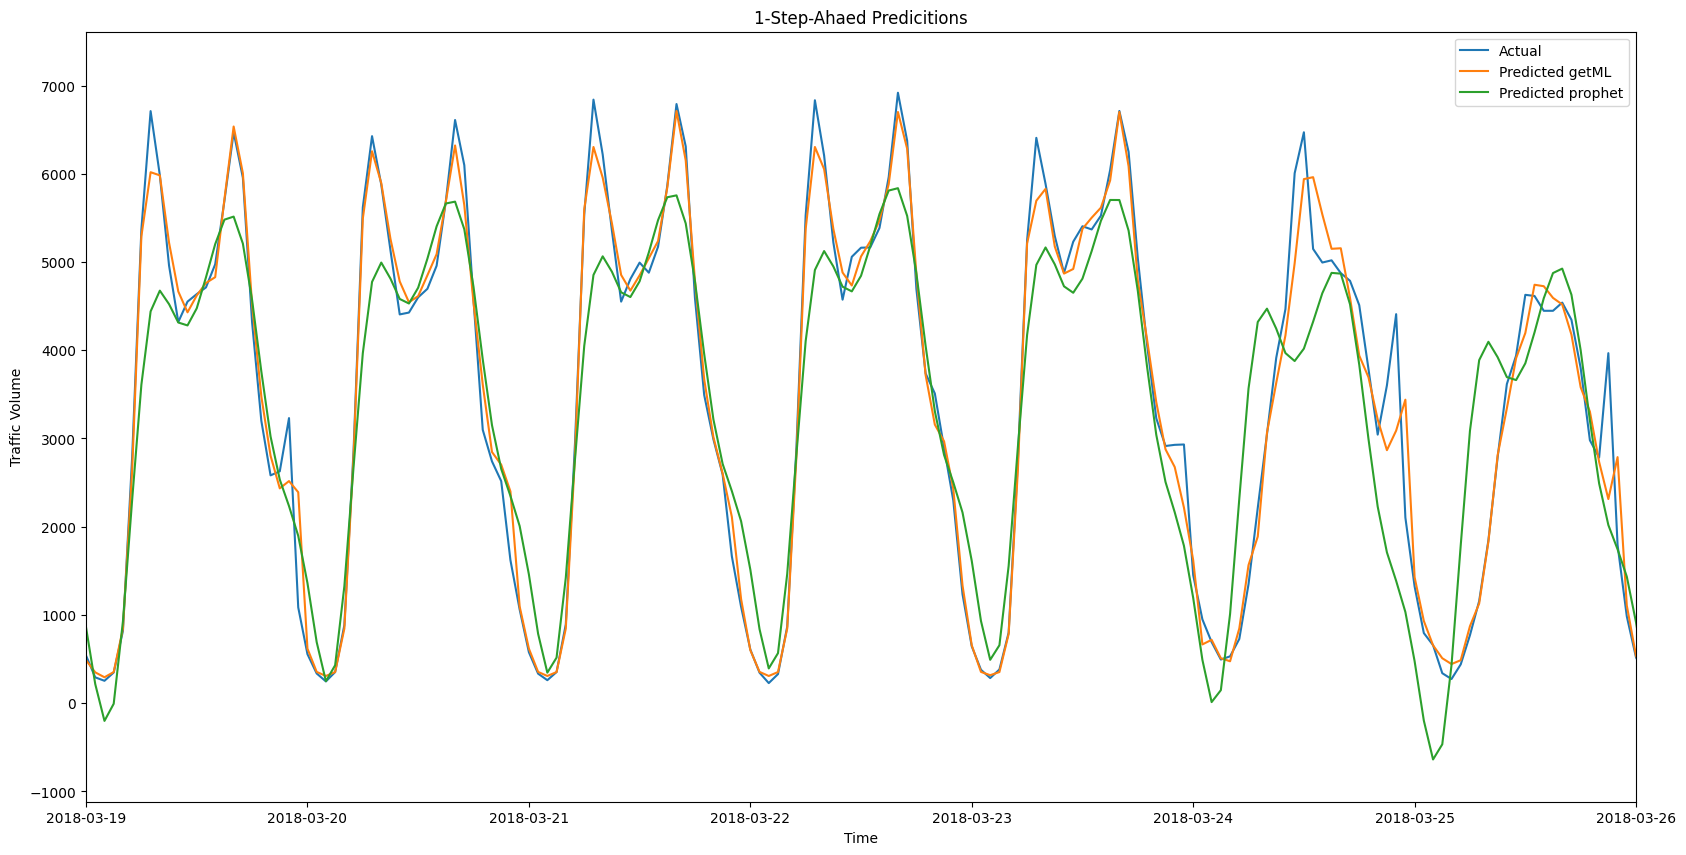

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
# Plot all together
ax.plot(
    time_series.test.population.ds,
    time_series.test.population.traffic_volume,
    label="Actual",
)
ax.plot(
    prediction_getml["ds"], prediction_getml.traffic_volume, label="Predicted getML"
)
ax.plot(prediction_prophet.ds, prediction_prophet.yhat, label="Predicted prophet")
plt.title("1-Step-Ahaed Predicitions")
plt.legend()
plt.ylabel("Traffic Volume")
plt.xlabel("Time")
# We shift the data by 5 days to let the plot start on a mondey
start_date = pd.Timestamp(year=2018, month=3, day=19)
end_date = pd.Timestamp(year=2018, month=3, day=26)
plt.xlim(start_date, end_date)

In [ ]:
prediction_getml[
    (prediction_getml.ds >= start_date) & (prediction_getml.ds <= end_date)
]

,traffic_volume,ds
96,488.241333,2018-03-19 00:00:00
97,349.636353,2018-03-19 01:00:00
98,294.066284,2018-03-19 02:00:00
99,353.199097,2018-03-19 03:00:00
100,845.676880,2018-03-19 04:00:00
...,...,...
260,2734.227051,2018-03-25 20:00:00
261,2313.482910,2018-03-25 21:00:00
262,2788.725098,2018-03-25 22:00:00
263,1107.663330,2018-03-25 23:00:00


In [ ]:
prediction_prophet[
    (prediction_prophet.ds >= start_date) & (prediction_prophet.ds <= end_date)
]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
96,2018-03-19 00:00:00,859.617951,-207.858174,1974.022755,540.0,2018-03-18 23:00:00
97,2018-03-19 01:00:00,216.459702,-889.354763,1306.151399,293.0,2018-03-19 00:00:00
98,2018-03-19 02:00:00,-200.431458,-1284.662499,878.980263,254.0,2018-03-19 01:00:00
99,2018-03-19 03:00:00,-6.085258,-984.172460,1046.820185,348.0,2018-03-19 02:00:00
100,2018-03-19 04:00:00,927.972706,-159.947263,1975.792030,819.0,2018-03-19 03:00:00
...,...,...,...,...,...,...
260,2018-03-25 20:00:00,2490.645008,1386.373695,3567.847457,2784.0,2018-03-25 19:00:00
261,2018-03-25 21:00:00,2019.153096,977.311072,3086.498967,3967.0,2018-03-25 20:00:00
262,2018-03-25 22:00:00,1744.073754,710.266119,2762.178865,1794.0,2018-03-25 21:00:00
263,2018-03-25 23:00:00,1434.614860,370.683908,2419.102388,984.0,2018-03-25 22:00:00


What can we take from this plot? The strong time-related patterns carry on to the testing set and the xgboost is able to incorporate this information to deliver highly accurate 1-step ahead predictions. Notice that Prophets additive components model results in negative predictions for the weekends' lows at night. We can also see an anomaly on March, 24 that neither model is able to predict (feel free to play with the window to verify that its an anomaly).

Now we benchmark the performance of h-step ahead forecasts. Remember, in the models, only deterministic features are incorporated. Here, we fit the h-step ahead forecast with Prophet. This is how Prophet is meant to be applied. We allow for multiplicative seasonalities to at least partially remedy the problem with negative predictions discussed above.

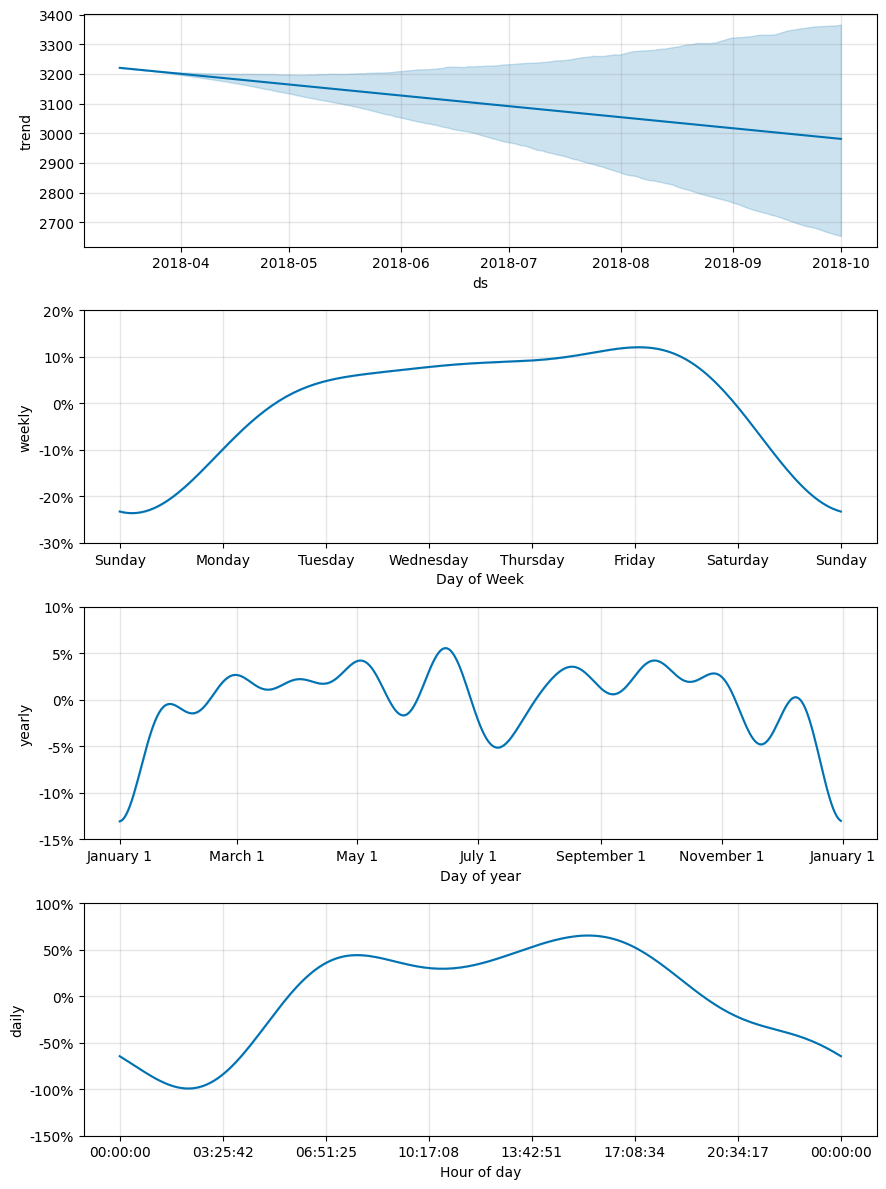

In [ ]:
# h-step ahead forecast with Prophet
from IPython.display import Image

try:
    forecast_prophet = pd.read_csv("assets/forecast_prophet.csv")
    forecast_prophet["ds"] = pd.to_datetime(forecast_prophet["ds"])
    display(Image(filename="components.png"))
except FileNotFoundError:
    import logging
    import cmdstanpy

    logger = logging.getLogger("cmdstanpy")
    logger.addHandler(logging.NullHandler())
    logger.propagate = False
    logger.setLevel(logging.CRITICAL)

    from prophet import Prophet

    traffic_prophet = traffic.to_pandas().rename(
        {"traffic_volume": "y"}, axis="columns"
    )

    model_forecast_prophet = Prophet(seasonality_mode="multiplicative")
    model_forecast_prophet.fit(traffic_prophet[traffic_prophet.ds < split_date])

    future = pd.DataFrame(traffic_prophet[traffic_prophet.ds >= split_date].ds)

    forecast_prophet = model_forecast_prophet.predict(future)

    forecast_prophet.to_csv(
        "assets/forecast_prophet.csv", encoding="utf-8", index=False
    )
    model_forecast_prophet.plot_components(forecast_prophet)
    pd.plotting.register_matplotlib_converters()

A typical Prophet components graph. 

Seasonalities are now applied multiplicatively, but the combination of the totally bottoming out daily cycle and the negative additive trend will result in negative predictions nonetheless.

Score the Prophet model.

In [ ]:
r2_forecast_prophet = (
    stats.pearsonr(
        forecast_prophet["yhat"].values,
        time_series.test.population.traffic_volume.to_numpy(),
    )[0]
    ** 2
)
print("R2:", r2_forecast_prophet)

R2: 0.8244945581002756


### 4. Conclusion

__Benchmarks against Prophet__

By design, Prophet isn't capable of delivering the 1-step ahead predictions we did with getML. To retrieve a benchmark in the 1-step case nonetheless, we mimic 1-step ahead predictions through cross-validating the model on a rolling origin. This gives Prophet an advantage as all information up to the origin is incorporated when *fitting* the model and a new fit is calculated for every 1-step ahead forecast.


__Results__

We have benchmarked getML against Facebook’s Prophet library on a univariate time series with strong seasonal components.
Prophet is made for exactly these sort of data sets, so you would expect this to be a home run for Prophet. The opposite is true - getML’s relational learning algorithms outperform Prophet's 1-step ahead predictions by ~15 percentage points:

In [ ]:
scores = [getml_score.rsquared, r2_prophet, r2_forecast_prophet]

pd.DataFrame(
    data={
        "Name": ["getML", "prophet 1-step-ahead", "prophet forecast"],
        "R-squared": [f"{score:.2%}" for score in scores],
    }
)

,Name,R-squared
0,getML,98.11%
1,prophet 1-step-ahead,83.33%
2,prophet forecast,82.45%


In [ ]:
getml.engine.shutdown()